In [1]:
import os
import time
import random
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
use_gpu = torch.cuda.is_available()
use_gpu

True

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Разведочный анализ

In [4]:
answers = pd.read_csv('answers.csv')
answers = answers.rename(columns={'Unnamed: 0': 'filenames'})
answers.head(10)

,filenames,1000_1,1000_2,500_1,500_2,100_1,100_2
0,train_0.png,3,2,0,2,2,3
1,train_1.png,2,2,1,1,2,3
2,train_2.png,3,3,1,2,2,0
3,train_3.png,2,3,0,0,3,1
4,train_4.png,0,1,1,2,0,1
5,train_5.png,3,0,0,1,2,2
6,train_6.png,2,3,0,2,0,1
7,train_7.png,1,2,3,0,2,3
8,train_8.png,2,1,2,2,3,0
9,train_9.png,1,0,3,0,3,1


In [5]:
answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filenames  10000 non-null  object
 1   1000_1     10000 non-null  int64 
 2   1000_2     10000 non-null  int64 
 3   500_1      10000 non-null  int64 
 4   500_2      10000 non-null  int64 
 5   100_1      10000 non-null  int64 
 6   100_2      10000 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 547.0+ KB


Визуализируем расределение значений количества купюр, одновременно находящихся на картинке

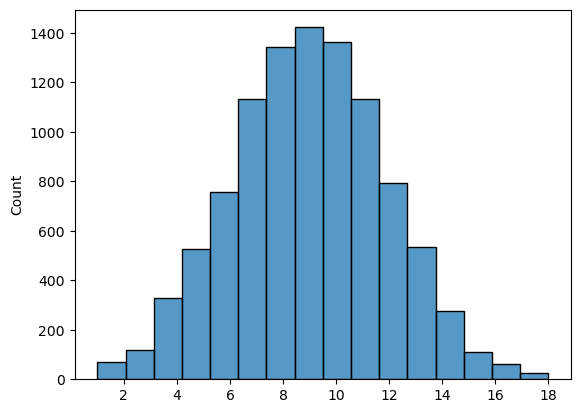

In [6]:
num_banknotes = answers.iloc[:, 1:].sum(axis=1)
ax = sns.histplot(num_banknotes, bins=16)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

Расределение нормальное, выбросы отсутствуют. В среднем на картинке около 9 купюр

Посмотрим сколько купюр одного номинала одной стороны, могут одновременнно находиться на картинке

In [7]:
for val in answers.columns[1:]:
    print(val, "-", sorted(answers[val].unique()))

1000_1 - [0, 1, 2, 3]
1000_2 - [0, 1, 2, 3]
500_1 - [0, 1, 2, 3]
500_2 - [0, 1, 2, 3]
100_1 - [0, 1, 2, 3]
100_2 - [0, 1, 2, 3]


Не более 3 купюр одного номинала одной стороны

Выведем общее количество купюр, находящихся на картинках

In [8]:
df = pd.DataFrame(columns=answers.iloc[:, 1:].columns)
for col in answers.iloc[:, 1:].columns:
    df[col] = answers[col].value_counts().sort_index()
df

,1000_1,1000_2,500_1,500_2,100_1,100_2
0,2454,2513,2519,2519,2493,2542
1,2505,2536,2490,2499,2484,2475
2,2536,2383,2542,2475,2512,2472
3,2505,2568,2449,2507,2511,2511


Количество купюр на картинках сбалансировано

In [9]:
numeric_answers = pd.read_csv('numeric_answers.csv')
numeric_answers.head(10)

,sum
0,6500
1,5500
2,7700
3,5400
4,2600
5,3900
6,6100
7,5000
8,5300
9,2900


In [10]:
numeric_answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sum     10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


<AxesSubplot:ylabel='Count'>

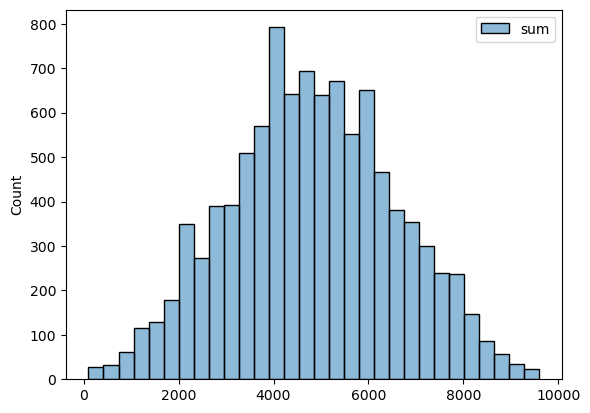

In [11]:
sns.histplot(numeric_answers, bins=30)

Значения столбца sum распределены нормально, выбросы отсутствуют

Посмотрим на картинку тренировачного датасета

train_1468.png


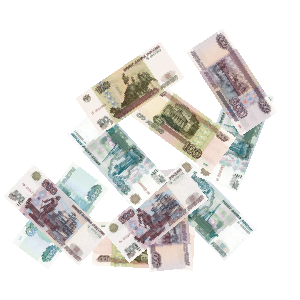

In [12]:
random_file = random.choice(os.listdir("./train"))
print(random_file)
Image.open(f"./train/{random_file}")

## Предобработка

In [13]:
data_dir = '.\\train'
train_dir = '.\\data\\train'
val_dir = '.\\data\\val'

In [18]:
def split_train_val_data(data_dir, train_dir, val_dir, train_ratio=0.8):
    """
    Разделяет данные из папки train на тренировочную и валидационную части,
    сохраняя результат в папке data
    """
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
        
    os.makedirs(train_dir, exist_ok=False)
    os.makedirs(val_dir, exist_ok=False)

    filenames = os.listdir(data_dir)
    random.shuffle(filenames)

    num_train_samples = int(train_ratio * len(filenames))
    num_val_samples = len(filenames) - num_train_samples

    train_filenames = filenames[:num_train_samples]
    val_filenames = filenames[num_train_samples:]

    for filename in train_filenames:
        src_path = os.path.join(data_dir, filename)
        dst_path = os.path.join(train_dir, filename)
        shutil.copy(src_path, dst_path)

    for filename in val_filenames:
        src_path = os.path.join(data_dir, filename)
        dst_path = os.path.join(val_dir, filename)
        shutil.copy(src_path, dst_path)

In [14]:
train_filenames = os.listdir(train_dir)
val_filenames = os.listdir(val_dir)

val_answers = answers[answers['filenames'].isin(val_filenames)]
train_answers = answers[answers['filenames'].isin(train_filenames)]

val_numeric_answers = numeric_answers.iloc[val_answers.index]
train_numeric_answers = numeric_answers.iloc[train_answers.index]

In [15]:
class MoneyDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, data_dir, answers, numeric_answers):

        self.data_dir = data_dir
        self.answers = answers
        self.numeric_answers = numeric_answers
        self.len_ = len(answers)

    def __len__(self):
        return self.len_
    
    def __getitem__(self, index):
        # преобразование изображений в тензоры PyTorch и нормализация входа
        data_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        file_path = os.path.join(self.data_dir, self.answers.iloc[index, 0])
        image = Image.open(file_path).convert('RGB')
        image = data_transforms(image)

        banknotes = torch.FloatTensor(self.answers.iloc[index, 1:].to_list())
        money = torch.LongTensor([self.numeric_answers.iloc[index].item()])

        return image, banknotes, money

In [16]:
train_dataset = MoneyDataset(train_dir, train_answers, train_numeric_answers)
val_dataset = MoneyDataset(val_dir, val_answers, val_numeric_answers)

train_loader = DataLoader(train_dataset, 
                          batch_size=128, 
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=128, 
                        shuffle=False)

In [17]:
for batch in val_loader:
    images, banknotes, money = batch
    print(images[0], banknotes[0], money[0], sep='\n')
    break

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.

## Обучение

In [18]:
loaders = {"train": train_loader, "val": val_loader}
# денежные номиналы
denom = torch.LongTensor([1000, 1000, 500, 500, 100, 100])
device = torch.device('cuda')

In [19]:
if use_gpu:
    device = torch.cuda.current_device()
    
    allocated = torch.cuda.memory_allocated(device)
    cached = torch.cuda.memory_cached(device)
    
    print(f'Занятая память: {allocated / 1024 ** 3} ГБ')
    print(f'Кэшированная память: {cached / 1024 ** 3} ГБ')

Занятая память: 0.0 ГБ
Кэшированная память: 0.0 ГБ


In [20]:
def train_model(model, criterion, optimizer, num_epochs=50): 
    since = time.time()

    best_model = model.state_dict()
    best_mae = 10000
    losses = {"train": [], "val": []}
    metrics = {"train": [], "val": []}

    for epoch in range(num_epochs):

        for phase, dataloader in loaders.items():

            running_loss = 0.0
            running_mae = 0

            if phase == 'train':
                model.train(True)  
            else:
                model.eval()

            for batch in dataloader:

                inputs, labels, money = batch

                if use_gpu:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(inputs)

                else:
                    with torch.no_grad():
                        outputs = model(inputs)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                predicted = torch.sum(torch.round(outputs.detach().cpu()) * denom, 1)
                running_mae += torch.sum(
                    torch.abs(money.flatten() - predicted)) / batch[0].shape[0]

            epoch_loss = running_loss / len(dataloader)
            epoch_mae = running_mae / len(dataloader)

            losses[phase].append(epoch_loss)
            metrics[phase].append(epoch_mae)
            
            if phase == "train":
                print('Epoch:', epoch)
            print('  {} Loss: {:.4f}\tMAE: {:.4f}'.format(
                phase, epoch_loss, epoch_mae))

            if phase == 'val' and epoch_mae < best_mae:
                best_mae = epoch_mae
                best_model = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best MAE: {:4f}'.format(best_mae))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model)
    return model, losses, metrics

## Предсказания

In [21]:
def evaluate(model):
    model.eval()
    
    running_mae = 0
    for batch in loaders['val']:
        
        inputs, labels, money = batch
        
        if use_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        predicted = torch.sum(torch.round(outputs.detach().cpu()) * denom, 1)
        running_mae += torch.sum(torch.abs(money.flatten() - predicted)) / batch[0].shape[0]

    return running_mae / len(loaders['val'])

In [22]:
def imshow(input, title=None):
    """Отображение тензора в виде изображения"""
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if title is not None:
        plt.title(title)

In [32]:
random_val_file = random.choice(os.listdir(val_dir))

In [24]:
def image_process(file, model):
    """Печать предсказанного и правильного ответа, а также самого изображения"""
    correct = val_answers[val_answers['filenames'] == file].iloc[:, 1:]
    correct = correct.values[0].tolist()
    print('Correct answer:', correct)

    data_transforms = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])

    image = Image.open(val_dir + '\\' + file).convert('RGB')
    image = data_transforms(image) 
    image = torch.unsqueeze(image, 0)

    outputs = model(image.to(device))
    predicted = torch.round(outputs.detach().cpu())
    print('Predicted answer:', predicted[0].tolist())

    image = image.squeeze()
    imshow(image, title=file)

## ResNet18

In [25]:
model_resnet = models.resnet18(pretrained=True)
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# на вход классификатору подается 512 признаков
num_features = 512
num_labels = len(train_answers.columns[1:])

model_resnet.fc = nn.Sequential(
    nn.Linear(num_features, 256), 
    nn.ReLU(), 
    nn.Linear(256, 128), 
    nn.ReLU(), 
    nn.Linear(128, num_labels),
)

loss_fn = nn.L1Loss(reduction='sum')
optimizer = optim.Adam(model_resnet.parameters())

if use_gpu:
    model_resnet = model_resnet.to(device)

In [27]:
model_resnet, losses, metrics = train_model(model_resnet, loss_fn, optimizer, num_epochs=100)

Epoch: 0
  train Loss: 385.3306	MAE: 820.5977
  val Loss: 431.1052	MAE: 853.9453
Epoch: 1
  train Loss: 226.3237	MAE: 429.7247
  val Loss: 295.1361	MAE: 588.4277
Epoch: 2
  train Loss: 186.2488	MAE: 316.4683
  val Loss: 238.5460	MAE: 653.4473
Epoch: 3
  train Loss: 170.5704	MAE: 264.2485
  val Loss: 297.7582	MAE: 783.6133
Epoch: 4
  train Loss: 160.3448	MAE: 246.5774
  val Loss: 235.3941	MAE: 458.5938
Epoch: 5
  train Loss: 153.9220	MAE: 226.5997
  val Loss: 268.6915	MAE: 766.2207
Epoch: 6
  train Loss: 146.8520	MAE: 203.9062
  val Loss: 187.6383	MAE: 343.4180
Epoch: 7
  train Loss: 140.0761	MAE: 159.4866
  val Loss: 200.4654	MAE: 265.2344
Epoch: 8
  train Loss: 125.2837	MAE: 120.8581
  val Loss: 180.0571	MAE: 332.9492
Epoch: 9
  train Loss: 125.0359	MAE: 121.1310
  val Loss: 248.5435	MAE: 446.8848
Epoch: 10
  train Loss: 123.2327	MAE: 112.5496
  val Loss: 349.2571	MAE: 1374.8047
Epoch: 11
  train Loss: 116.3750	MAE: 88.7029
  val Loss: 281.8637	MAE: 337.7832
Epoch: 12
  train Loss: 11

In [35]:
torch.save(model_resnet.state_dict(), "model_resnet.pt")

In [27]:
state_dict = torch.load("model_resnet.pt")
model_resnet.load_state_dict(state_dict)

<All keys matched successfully>

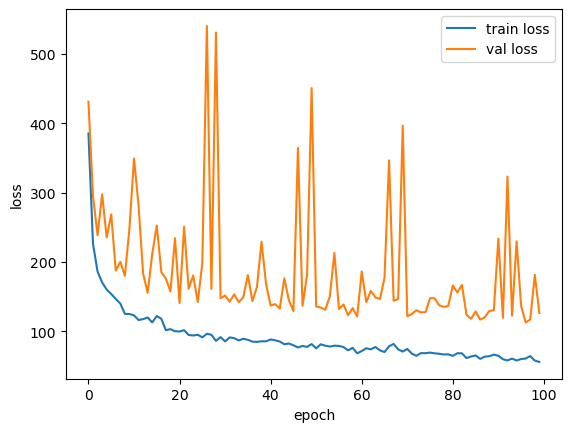

In [28]:
plt.plot(losses['train'], label='train loss')
plt.plot(losses['val'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

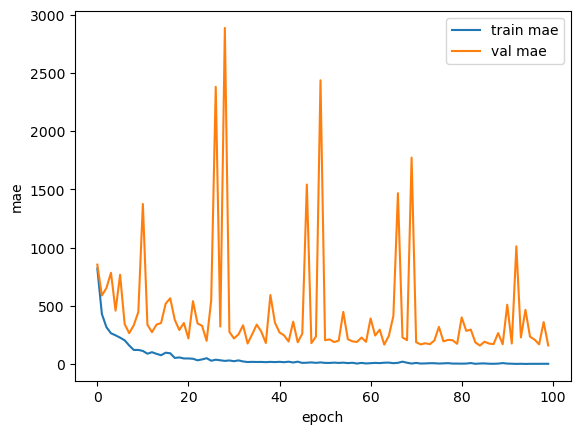

In [29]:
plt.plot(metrics['train'], label='train mae')
plt.plot(metrics['val'], label='val mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()
plt.show()

In [30]:
print("MAE: {0:.4f}".format(evaluate(model_resnet)))

MAE: 159.5605


In [36]:
random_val_file

'train_4777.png'

Выведем на экран одно изображение и предсказания к нему

Correct answer: [1, 1, 2, 3, 0, 1]
Predicted answer: [1.0, 1.0, 2.0, 3.0, 0.0, 1.0]


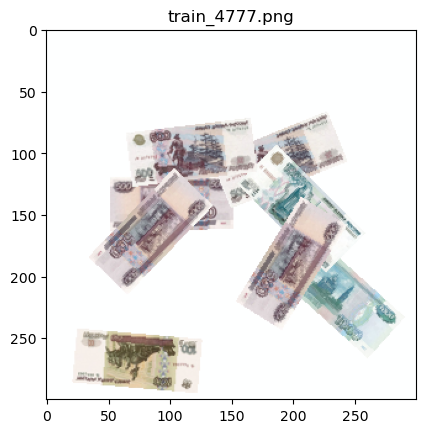

In [33]:
image_process(random_val_file, model_resnet)

Количество каждой купюры определяется верно